In [1]:
# import libraries here

import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_images(image_directory):
    # Get the list of image file names
    image_files = [f for f in os.listdir(image_directory) if f.endswith('.jpg') or f.endswith('.png')]

    # Initialize empty lists to store images and labels
    images = []
    labels = []
    
    for file_name in image_files :
        image_path = os.path.join(image_directory, file_name)
        
        image = Image.open(image_path)
        
        # Convert the image to a numpy array and append to the images list
        images.append(np.array(image))
        
        # Extract the label from the file name (assuming the label is the file name without the extension)
        label = file_name.split('_')[0]
        labels.append(label)
        
    return images, labels
    

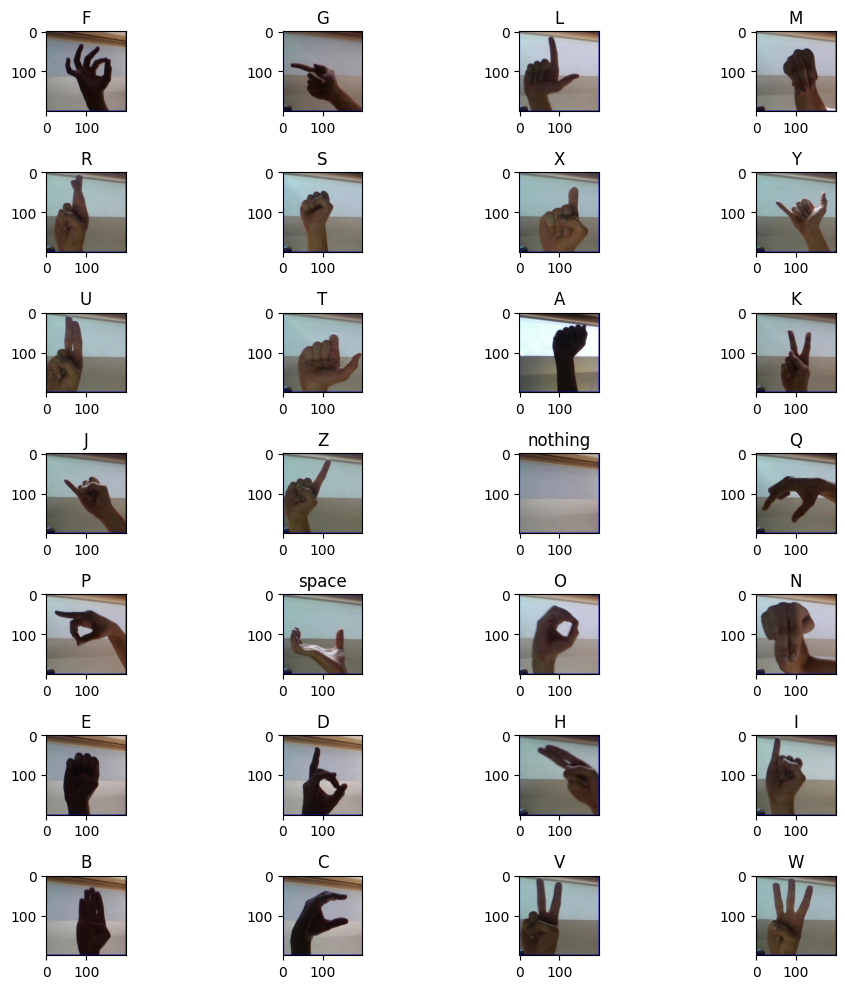

In [3]:
signs, labels = load_images("images")

plt.figure(figsize=(10,10))

for i, (image, label) in enumerate(zip(signs, labels)):
    if i < 28:
        plt.subplot(7, 4, i + 1)
        plt.imshow(image)
        plt.title(label)
plt.tight_layout()
plt.show()

# Edge detection

To accomplish our inital goal of detecting sign language in images, we are first performing edge detection. Edges can be described in an image as pixel intensity staying the same along the edge directions. Applying a gaussian filter before detecting edges makes it easier to identify edges in an image. To find edges we are implementing the sobel edge detection method, and canny edge detection method.

## Sobel Edge Detection

This method uses the gradient in both $x$ and $y$ direction to find edges. 

When there is hardly any change in the $x$ direction this signifies and edge along the $y$ direction $$I_x = 0$$

Whereas, hardly any change in the $y$ direction signifies an edge along the $x$ direction $$I_y = 0$$

Finding the image gradients involves convolving the image with a sobel filter for the respective direction. The sobel filters are defined as

$$sobel_x = \begin{bmatrix}
    -1 & 0 & 1 \\
    -2 & 0 & 2 \\
    -1 & 0 & 1 \end{bmatrix}$$

$$sobel_y = \begin{bmatrix}
    1 & 2 & 1 \\
    0 & 0 & 0 \\
    -1 & -2 & -1 \end{bmatrix}$$

## Canny Edge Detection

The Canny edge detection method is a highly popular and most used method for finding edges. The four step process includes:

1. Noise Reduction - by applying a gaussian filter to reduce noise.
2. Calculating the Intensity Gradient of the Image - Finding the intensity gradient magnitude and direction of each pixel of the image.
$$G = \sqrt(G_x^2 + G_y^2)$$
$$\Theta = \arctan(G_x / G_y)$$
3. Suppression of False Edges - Compare pixels to their neighbors in the positive and negative gradient direction. If the gradient magnitude of the pixel is greater than its neighboring pixel it is left unchanged, otherwise it is set to zero.
4. Hysteresis Thresholding - The gradient magnitudes are then compared with two different threshold values.



https://learnopencv.com/edge-detection-using-opencv/




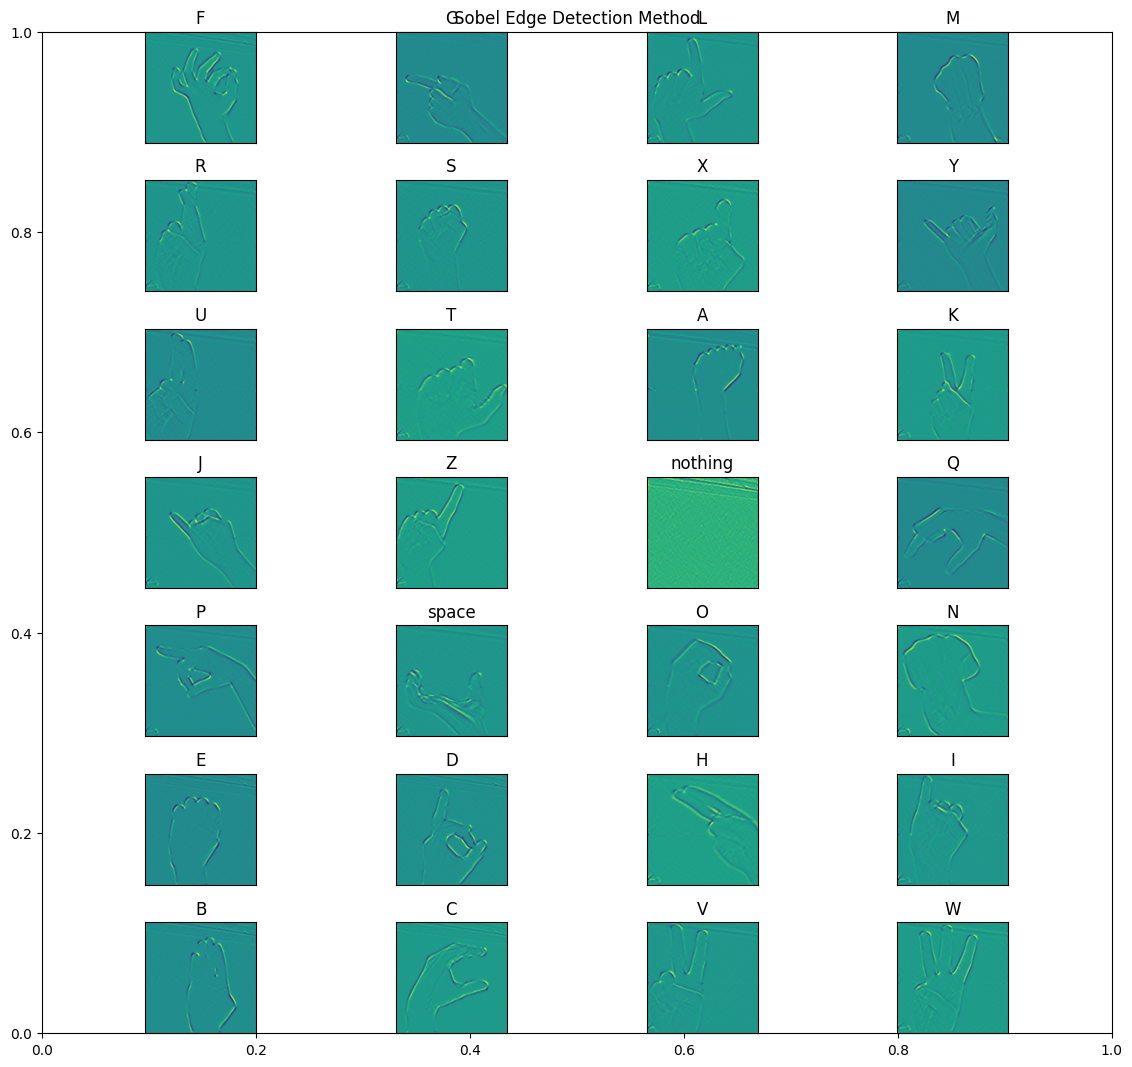

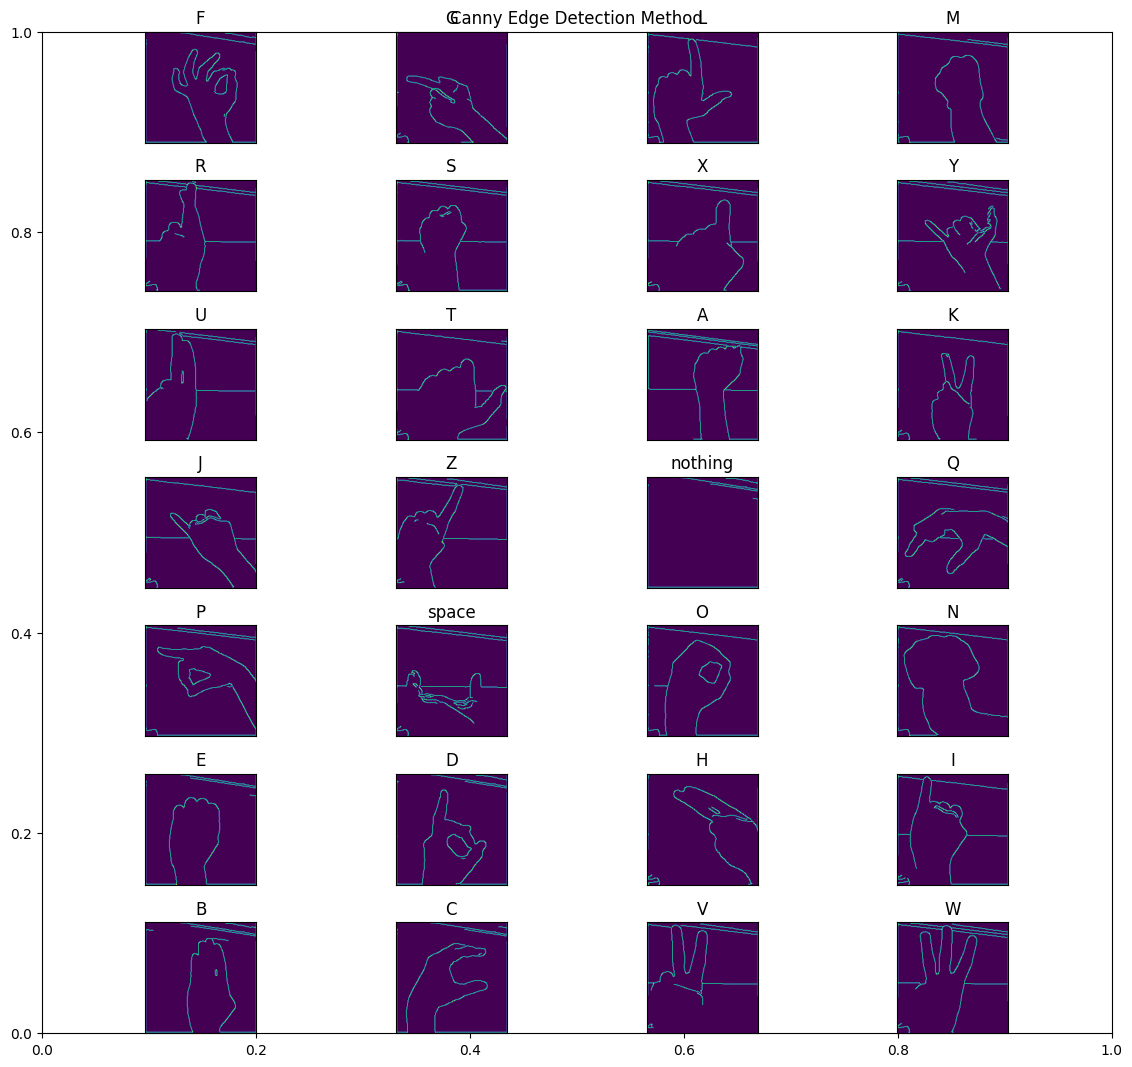

In [11]:
def sobel_edge(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (3,3), 0)
    
    sobelxy = cv2.Sobel(src=blur_img, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
    
    return sobelxy

def canny_edge(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur_img = cv2.GaussianBlur(gray_img, (3,3), 0)
    
    canny_img = cv2.Canny(image=blur_img, threshold1=100, threshold2=200)
    
    return canny_img

sobel_imgs = []
canny_imgs = []

def plot_sobel_edge_imgs(signs,labels):
    plt.figure(figsize=(11,11))
    
    plt.title("Sobel Edge Detection Method")
    # need to find a way to show title more clearly
    
    for i, (image, label) in enumerate(zip(signs, labels)):
        sobel_img = sobel_edge(image)
        sobel_imgs.append(sobel_img)
        
        plt.subplot(7,4,i+1)
        plt.imshow(sobel_img)
        plt.title(label)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
    plt.tight_layout()
    plt.show()
    
def plot_canny_edge_imgs(signs,labels):
    plt.figure(figsize=(11,11))
    
    plt.title("Canny Edge Detection Method")
    # need to find a way to show title more clearly
    
    for i, (image, label) in enumerate(zip(signs, labels)):
        canny_img = canny_edge(image)
        canny_imgs.append(canny_imgs)
        
        plt.subplot(7,4,i+1)
        plt.imshow(canny_img)
        plt.title(label)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
    plt.tight_layout()
    plt.show()
        
plot_sobel_edge_imgs(signs,labels)
plot_canny_edge_imgs(signs,labels)



# Corner detection

Once we have found the edges using one of the edge detection methods, we can now find corners. Given a window to sweep an image, corners are found when there is a signicant change of pixel intersity in both the $x$ and $y$ coordinates. Our first implementation of edge detection is using the **Harris Corners** technique. 

The **Harris Corner Detection** is as follows:
1. Computing the gradient in both $x$ and $y$ directions.
2. Computing the $H$ Matrix from the gradients and a smoothing operation using a gaussian window filter.
3. Computing the scoring functions
4. Finding points with a large response (threshold $f$)
5. FInding local maxima of $f$ after thresholding.

The $H$ matrix is defined as:
$$ H = \begin{bmatrix} A & B \\ B & C \end{bmatrix} = \sum_{(x, y) \in W} w_{x, y} \begin{bmatrix}
I_x^2 & I_x I_y \\ I_x I_y & I_y^2
\end{bmatrix} $$

The scoring functions $f$ is defined as:
$$ f = min(\lambda_1, \lambda_2) $$
$$ f = \frac{\text{det}(H)}{\text{tr}(H)} $$



### ***References***
- https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html
- Professor Stein's lectures




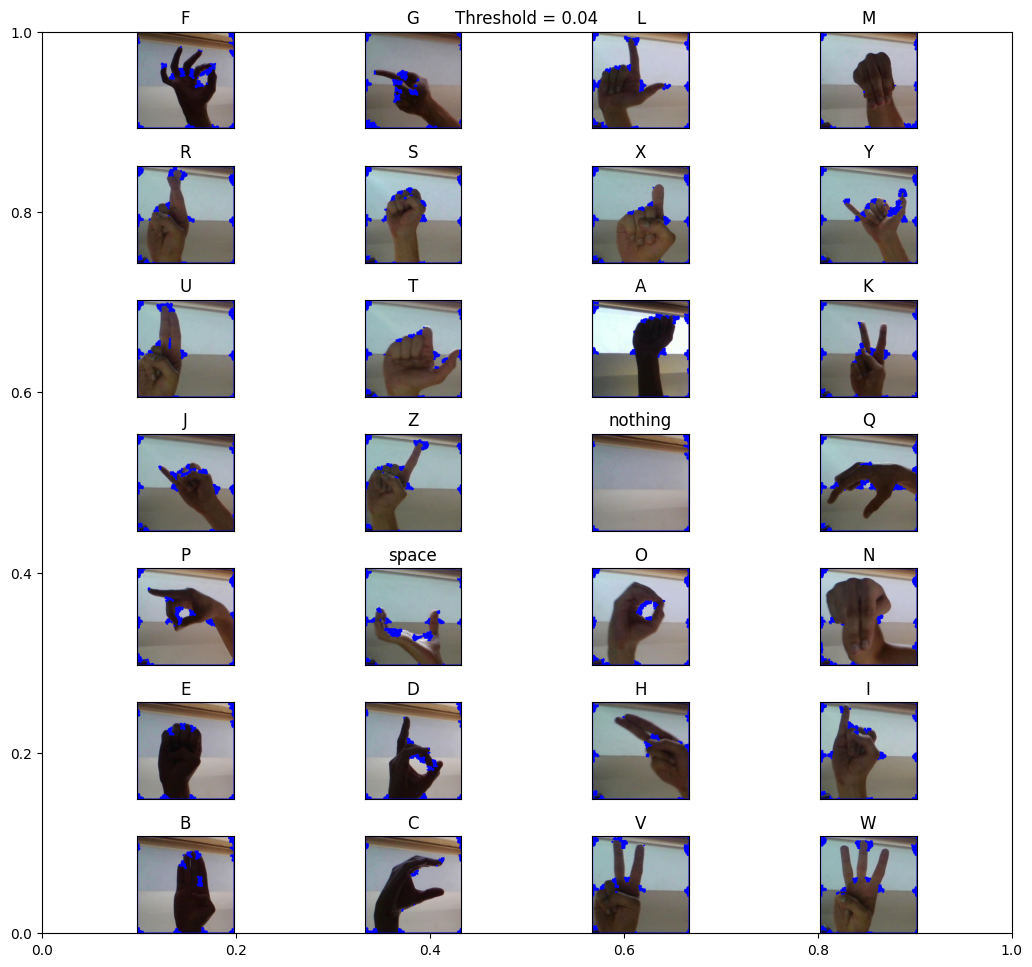

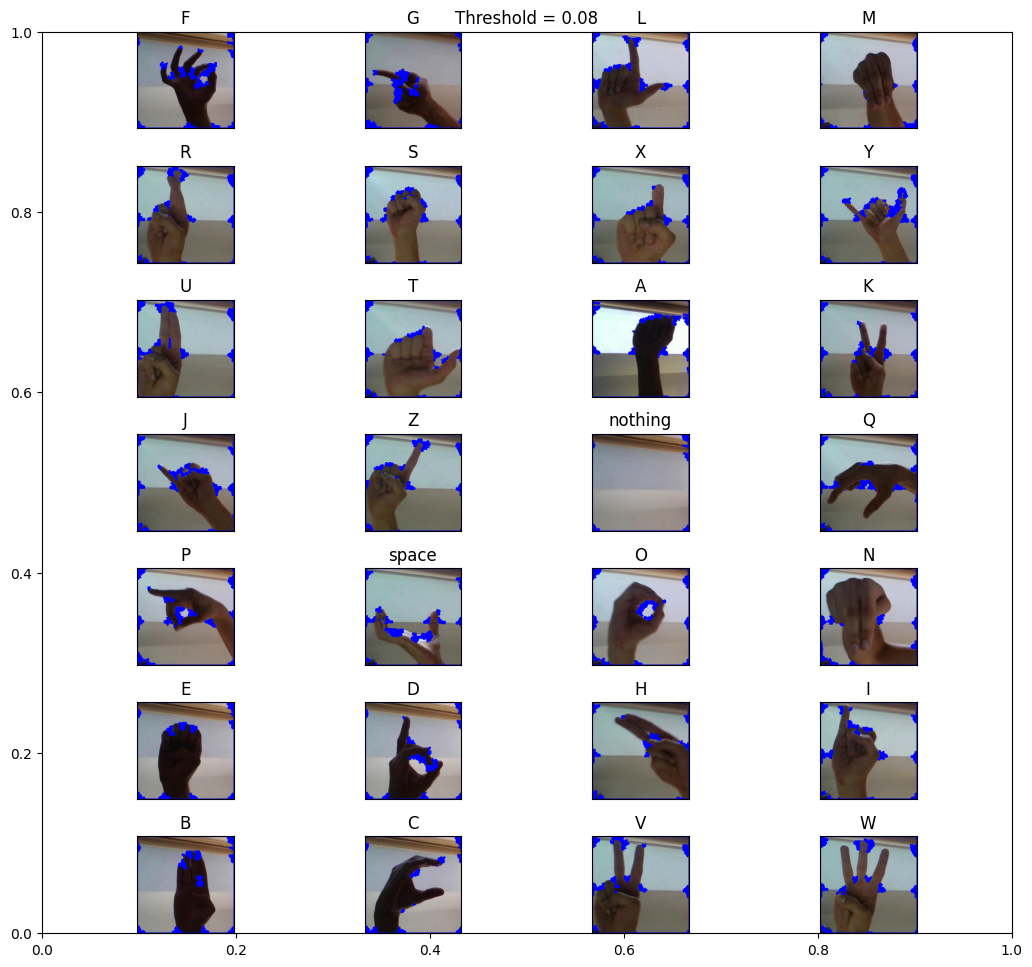

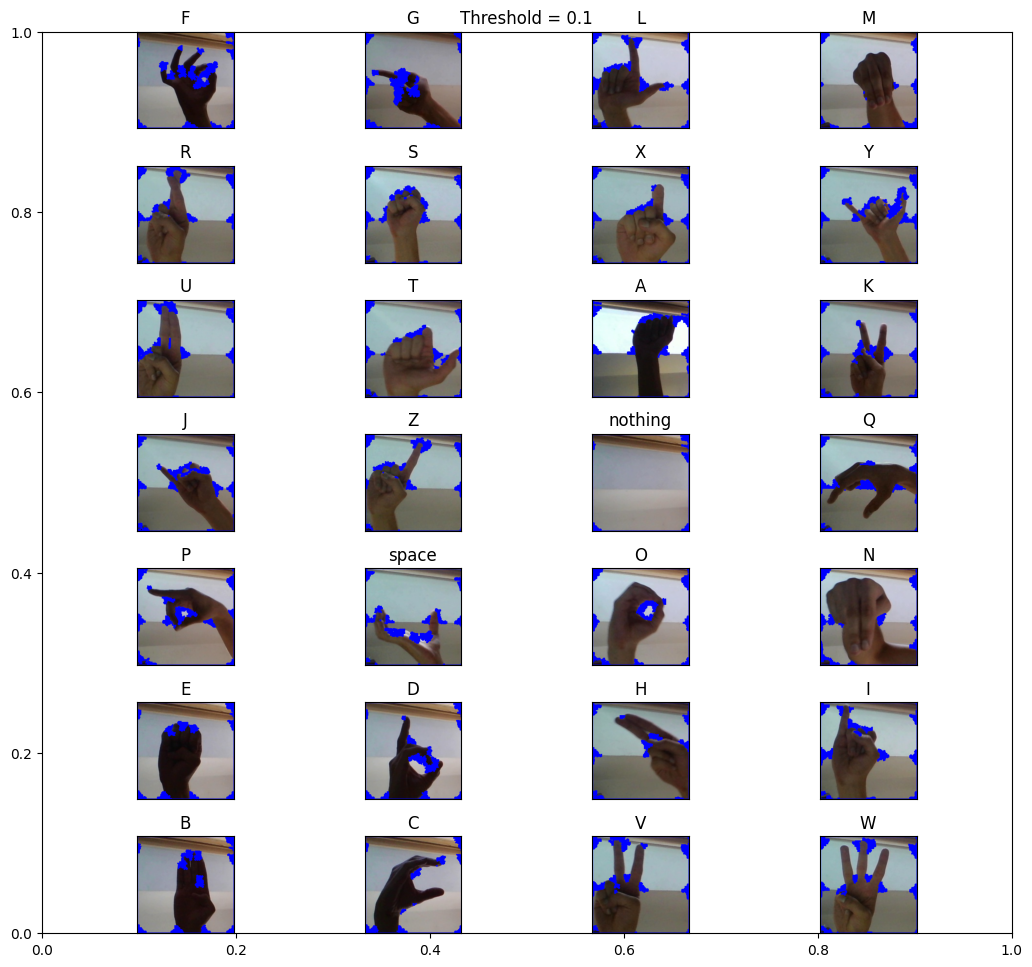

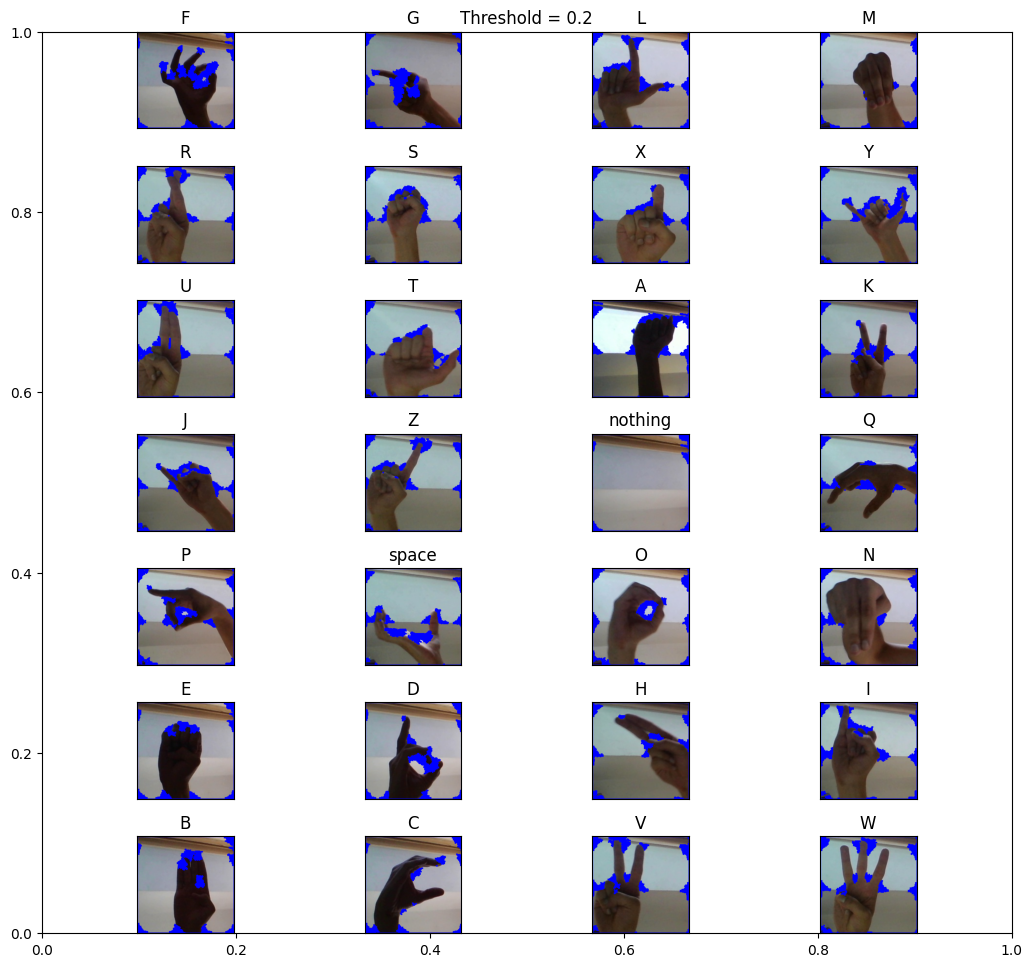

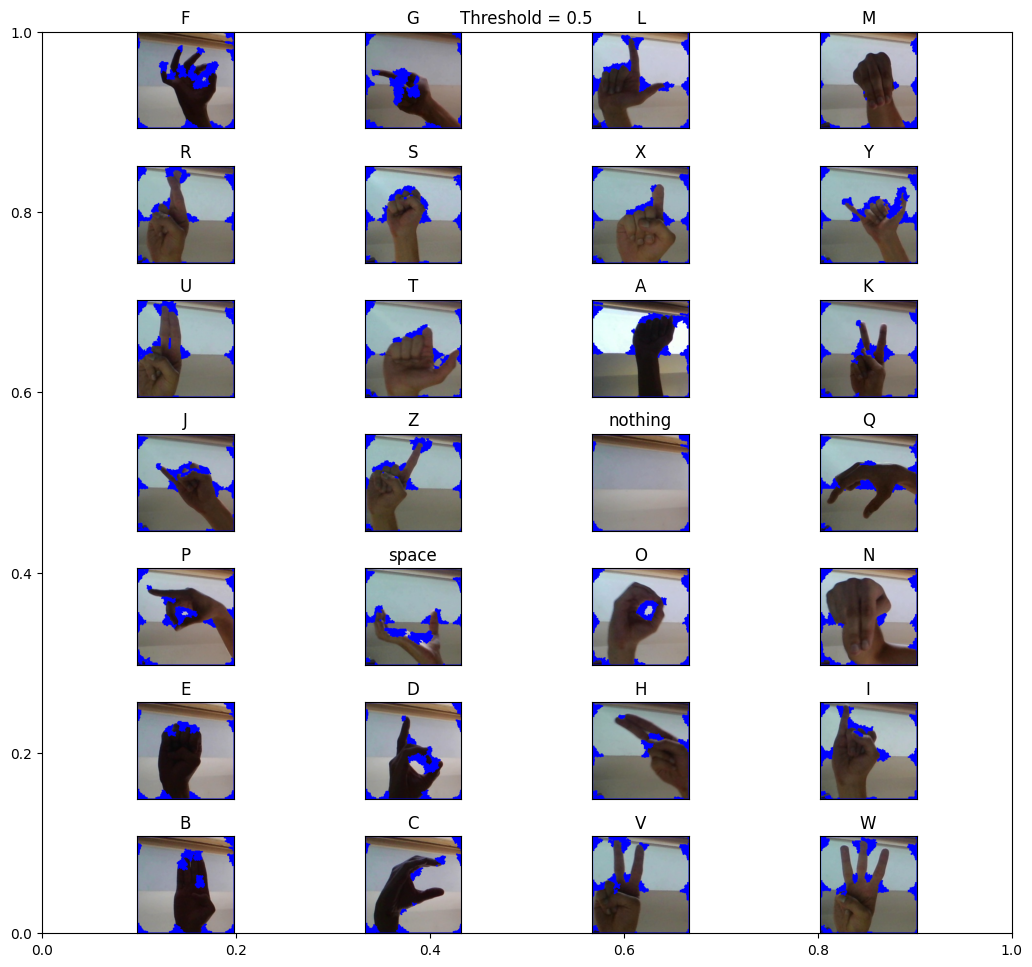

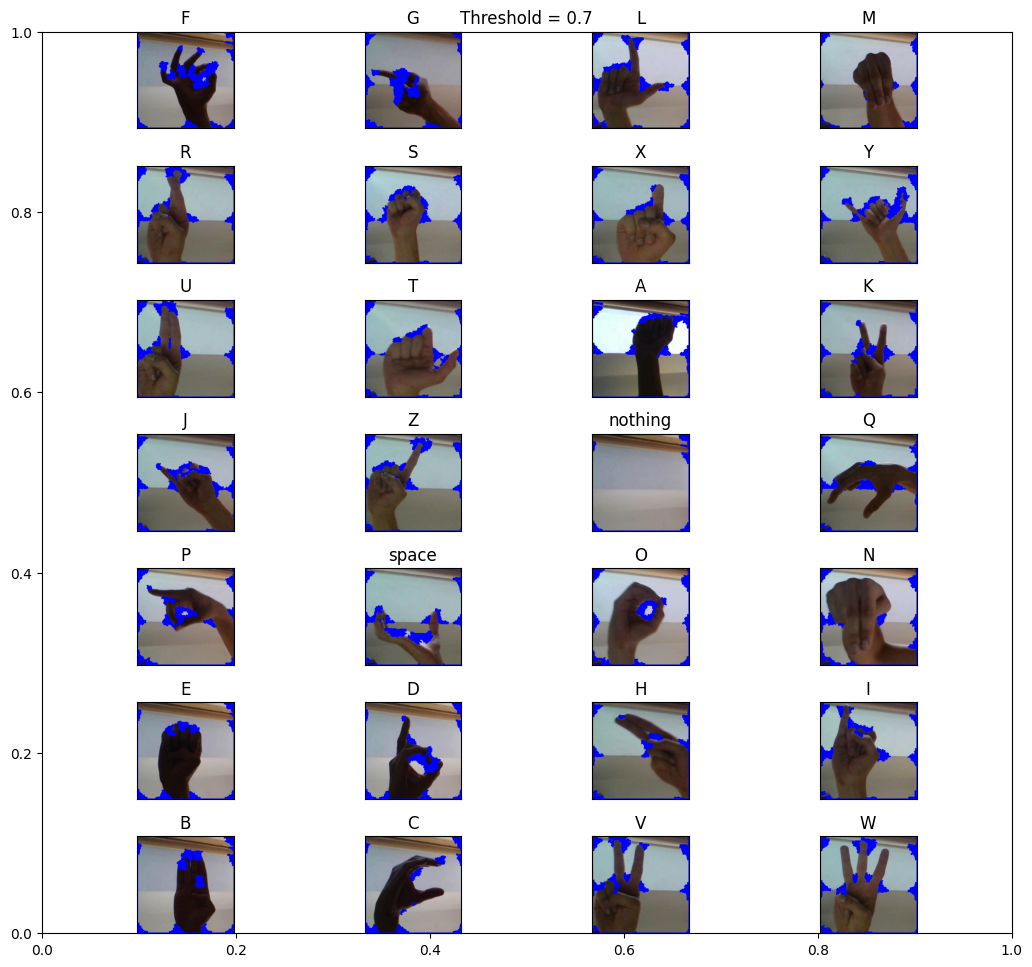

In [18]:
def harris_corner(img, threshold):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_img = np.float32(gray_img)
    harris_img = cv2.cornerHarris(gray_img,3,3,threshold)
 
    #result is dilated for marking the corners, not important
    harris_img = cv2.dilate(harris_img,None)
 
    # Threshold for an optimal value, it may vary depending on the image.
    img[harris_img>0.01*harris_img.max()]=[0,0,255]
    return img

def plot_harris_corners(signs,labels,threshold):
    plt.figure(figsize=(10,10))
    plt.title(f"Threshold = {threshold}")
    for i, (image, label) in enumerate(zip(signs, labels)):
        harris = harris_corner(image,threshold)
        plt.subplot(7,4,i+1)
        plt.imshow(harris)
        plt.title(label)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
    plt.tight_layout()
    plt.show()
    
different_thresholds = [0.04, 0.08, 0.1, 0.2, 0.5, 0.7]

for thresholds in different_thresholds:
    plot_harris_corners(signs,labels,thresholds)

